#Site traffic forecasting - Competitive Analysis

This script is used to predict the brand behavior in terms of sessions for the next 6th months, and then the Striking distance is summarized by different percentages to be able to see how this strategy could work in the last 4th months.


---


###**Pre-requeriments**
Python 3.7 at least
####Libraries
**for Google Analytics API:**

*   google-api-python-client
*   apiclient.discovery
*   oauth2client.service_account

**for processing the data:**

*   Pandas
*   Numpy
*   Fbprophet

####Google Analytics API

To start using Google Analytics API, first use [the setup tool](https://https://console.developers.google.com/start/api?id=analytics&credential=client_key), which guides you through creating a project in the Google API Console, enabling the API, and creating credentials.

*   SCOPES = 'https://www.googleapis.com/auth/analytics.readonly'
*   API Key = xxxxxxxxxxxxxxxxxxx
*   KEY_FILE_LOCATION = 'xxxxxxxxxxxxxxxx'
*   VIEW_ID = 'xxxxxxxxxxxxxxxxx'
*   start_date = 'yyyy-mm-dd'
*   end_date = 'yyyy-mm-dd'

Having the credentials above, proceed with the request.

In order to get a yearly seasonality it would better to get at least the last 2 years of historical data.

###**Fbprophet**

**Generating the dataframe.** 
Assigning the GA dataset to a dataframe for fbprophet.

**Generating the Holydays.** 
Creating a list that contains the algorithms updates from Google since 2017. Assumes a 14 day window after the update to give time for changes to reflect.

**Training the Fbprophet model.**
Since a Reports SEO perspective, the best approach to generate the predictions is for half a year (182).

**Plotting the forcast.**
After train the model, and get the prediction, a chart is shown with the seasonality of the data splitted in Trend, yearly and weekly. The Holidays are just the Google Core updates added.

###**Forcasting with incremental traffic**

####Preprocessing the dataset

Resampling the dataset to monthly periods, to facilitate the striking distance calculus.

####Calculating the Striking distance incrementals by Month 

**Getting the Striking distance from Ranking Analysis.**
This value is taken from Ranking Analysis --> SUB-DATASETS --> Subtotal ranking by non branded keywords and page --> no_branded[1]['Search Volume'].

**Getting the incremental percentages**
The incremental percentages are calculated multipilying the Striking distance MSV by 10, 25 and 50%.

**Finding the percentage variance per month**
A for loop is used to find the percentage variance month by month.

**Finding the incremental percentage for the last 4th Months**
Running a for loop to calculate the incremental percentage for the las 4th Months

**Plotting chars**
Dropping the percentage column to facilitate plotting the chart. The char shown the forecasting natural sessions (last 6th Months) and their incrementals by percentage, usign a stackplot graph.


## Needed Installs and Libraries




In [1]:
#Libraries for Google Analytics API
!pip install --upgrade google-api-python-client
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials

#Libraries for data proccessing
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 7.5 MB 4.2 MB/s 
  Attempting uninstall: google-auth-httplib2
    Found existing installation: google-auth-httplib2 0.0.4
    Uninstalling google-auth-httplib2-0.0.4:
      Successfully uninstalled google-auth-httplib2-0.0.4
  Attempting uninstall: google-api-python-client
    Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
earthengine-api 0.1.283 requires google-api-python-client<2,>=1.12.1, but you have google-api-python-client 2.22.0 which is incompatible.


##Google Analytics API

###GA Credentials

In [2]:
SCOPES = ['https://www.googleapis.com/auth/analytics.readonly']
KEY_FILE_LOCATION = 'xxxxxxxxxxxxxxxx'
VIEW_ID = 'xxxxxxxxxxxxxxxxx'
credentials = ServiceAccountCredentials.from_json_keyfile_name(KEY_FILE_LOCATION, SCOPES)
analytics = build('analyticsreporting', 'v4', credentials=credentials)

FileNotFoundError: ignored

###GA Request to get the dataset

In [ ]:
#Date period to pull 
start_date= input("Enter your start date (yyyy-mm-dd): ")
end_date= input("Enter your end date (yyyy-mm-dd): ")

In [ ]:
#Creating the request
response = analytics.reports().batchGet(body={
  'reportRequests': [{
  'viewId': VIEW_ID,
  'dateRanges': [{'startDate': start_date, 'endDate': end_date}],
  'metrics': [
    {"expression": "ga:sessions"}
  ], "dimensions": [
    {"name": "ga:date"}
  ],
"filtersExpression":"ga:channelGrouping=~Organic",
"includeEmptyRows": "true"
}]}).execute()

###Getting the dataset manually from GA

In [3]:
from google.colab import files
upload = files.upload()

for fn in upload.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(upload[fn])))
traffic = pd.read_csv(fn)
traffic

Saving knorr sessions.csv to knorr sessions.csv
User uploaded file "knorr sessions.csv" with length 21527 bytes


,Day Index,Sessions
0,1/1/2018,1934
1,1/2/2018,1724
2,1/3/2018,1745
3,1/4/2018,1626
4,1/5/2018,2011
...,...,...
1349,9/11/2021,1298
1350,9/12/2021,1289
1351,9/13/2021,1317
1352,9/14/2021,1351


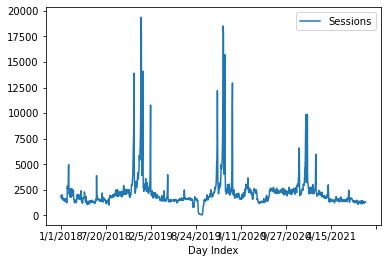

In [4]:
traffic.set_index('Day Index').plot();

##Applying Fbprophet


###Converting columns into FB prophet names

In [5]:
traffic.columns = ["ds", "y"]
traffic.head()

,ds,y
0,1/1/2018,1934
1,1/2/2018,1724
2,1/3/2018,1745
3,1/4/2018,1626
4,1/5/2018,2011


In [6]:
#Assigning the requested dataset to a fppropeth dataframe
list_values = []
for x in response["reports"][0]["data"]["rows"]:
list_values.append([x["dimensions"][0],x["metrics"][0]["values"][0]])
df_sessions = DataFrame(list_values,columns=['ds','y'])

IndentationError: ignored

###Holidays (one time events) using Google Core updates

Updates until June 02, 2020 are added. You can add a date to the array if needed in the format YYYY-MM-DD. Assumes a 14 day window after the update to give time for changes to reflect. You can adjust this with upper_window if needed.

In [7]:
updates = pd.DataFrame({
  'holiday': 'Core Update',
  'ds': pd.to_datetime(['2015-07-17', '2016-01-08',
                        '2016-09-27', '2017-03-08', '2017-07-09', '2018-03-08', '2018-04-17',
                        '2018-08-01', '2019-03-12', '2019-06-03', '2019-09-24', '2019-10-25',
                        '2019-12-09', '2020-01-13', '2020-05-04', '2020-12-03', '2021-02-10',
                        '2021-04-08', '2021-06-02', '2021-07-01', '2021-07-26',]),
  'lower_window': 0,
  'upper_window': 14,
})
updates

,holiday,ds,lower_window,upper_window
0,Core Update,2015-07-17,0,14
1,Core Update,2016-01-08,0,14
2,Core Update,2016-09-27,0,14
3,Core Update,2017-03-08,0,14
4,Core Update,2017-07-09,0,14
5,Core Update,2018-03-08,0,14
6,Core Update,2018-04-17,0,14
7,Core Update,2018-08-01,0,14
8,Core Update,2019-03-12,0,14
9,Core Update,2019-06-03,0,14


###Creating Forecast

Forecasting by default has periods = 365, which makes a forecast of one year. You can adjust this to forecast shorter or longer periods.

In [8]:
m = Prophet(holidays=updates).fit(traffic)
future = m.make_future_dataframe(periods=182)#182 days = 6 months
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1531,2022-03-12,1614.748390,17.562210,3157.503157
1532,2022-03-13,1746.345901,194.213554,3160.921370
1533,2022-03-14,1579.290508,72.121060,3114.916028
1534,2022-03-15,1484.757365,-108.694017,3148.742463
1535,2022-03-16,1415.354949,-175.995003,2954.731986


##Plotting the Forecast

You may need to adjust the ylabel to indicate the scale such as thousands, millions, etc. Press the play button to re-run this cell and see the updates.

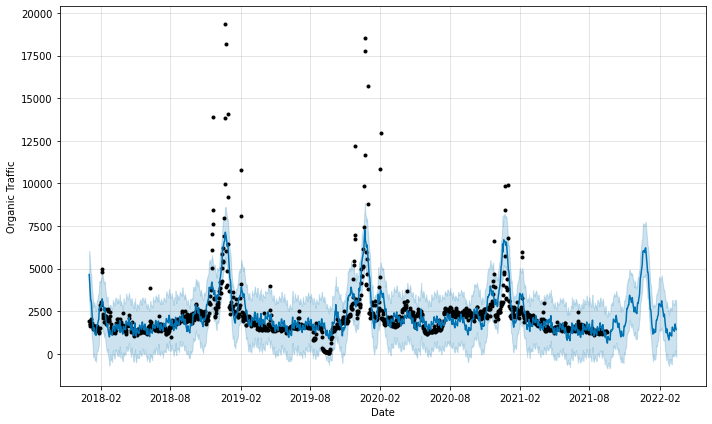

In [9]:
from fbprophet.plot import plot_forecast_component
fig = m.plot(forecast, xlabel='Date', ylabel='Organic Traffic')
#ax.set_title('Traffic Forecast')
fig.show()

In [10]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(m, forecast)

This Chart shows the seasonality of the data splitted in Trend, yearly and weekly. The Holidays are just the Google Core updates added.

In [11]:
plot_components_plotly(m, forecast)

##Forecasting with incremetal traffic

###Preprocessing the dataset

In [12]:
#Setting the Dataframe as datatime by changing its index using the dates column.
forecast['ds'] = pd.to_datetime(forecast['ds'] )
forecast = forecast.set_index('ds')

In [13]:
#Resampling the dataset to monthly periods
forecast=forecast.resample('M').sum()
forecast__=forecast['yhat']

In [14]:
#taking the last 12 months to calculate the incremental percentages
forecast__=forecast__.tail(12)
forecast__=forecast__.to_frame()
forecast__=forecast__.reset_index()
forecast__=forecast__.rename(columns={"ds": "Month index", "yhat": "Sessions"})

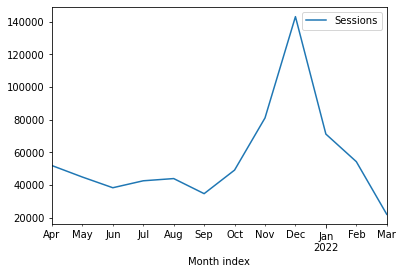

In [15]:
forecast__.set_index('Month index').plot();


###Calculating the Striking distance incrementals by month


In [16]:
#MSV--> Monthly search volume average for the last 12 months.
MSV=615670 #this value is taken from Ranking Analysis --> SUB-DATASETS --> Subtotal ranking by non branded keywords and page --> no_branded[1]['Search Volume']
MSV_inc_1=MSV*0.1
MSV_inc_2=MSV*0.25
MSV_inc_3=MSV*0.5
print(MSV)
print(MSV_inc_1,MSV_inc_2,MSV_inc_3)

615670
61567.0 153917.5 307835.0


###Finding the percentage variance per month

In [17]:
#Running a for loop to find the percentage per month
j=[]
for x in range (len(forecast__)):
  a=((forecast__.iloc[x,1]/forecast__.iloc[x-1,1])-1)*100
  j.append(a)
forecast__['perc']=j
forecast__.iloc[0,2]=0
forecast__

,Month index,Sessions,perc
0,2021-04-30,51876.467940,0.000000
1,2021-05-31,44856.730349,-13.531641
2,2021-06-30,38307.525694,-14.600272
3,2021-07-31,42565.078047,11.114141
4,2021-08-31,43921.415782,3.186504
5,2021-09-30,34689.276296,-21.019676
6,2021-10-31,49114.918354,41.585307
7,2021-11-30,81031.566197,64.983612
8,2021-12-31,143035.882250,76.518719
9,2022-01-31,71157.548125,-50.251960


###Finding the incremental percentage for the last 4 Months

In [18]:
#Running a for loop to calculate the last 4 months with the incremental percentage
j=[0]*8
k=[0]*8
l=[0]*8
for x in range (len(forecast__)-8):
  a=((MSV_inc_1*forecast__.iloc[x+7,2])/100)+MSV_inc_1
  j.append(a)

  b=(MSV_inc_2*(forecast__.iloc[x+7,2]/100)+MSV_inc_2)
  k.append(b)

  c=(MSV_inc_3*(forecast__.iloc[x+7,2]/100)+MSV_inc_3)
  l.append(c)
#Adding the lists to the dataframe
forecast__['10%']=j
forecast__['25%']=k
forecast__['50%']=l
pd.options.display.float_format = '{:.2f}'.format
forecast__

,Month index,Sessions,perc,10%,25%,50%
0,2021-04-30,51876.47,0.00,0.00,0.00,0.00
1,2021-05-31,44856.73,-13.53,0.00,0.00,0.00
2,2021-06-30,38307.53,-14.60,0.00,0.00,0.00
3,2021-07-31,42565.08,11.11,0.00,0.00,0.00
4,2021-08-31,43921.42,3.19,0.00,0.00,0.00
5,2021-09-30,34689.28,-21.02,0.00,0.00,0.00
6,2021-10-31,49114.92,41.59,0.00,0.00,0.00
7,2021-11-30,81031.57,64.98,0.00,0.00,0.00
8,2021-12-31,143035.88,76.52,101575.46,253938.65,507877.30
9,2022-01-31,71157.55,-50.25,108677.28,271693.20,543386.40


###Plotting the Char

In [19]:
#Dropping the percentage column to facilitate plotting the chart
forecast__=forecast__.drop(columns=['perc'])

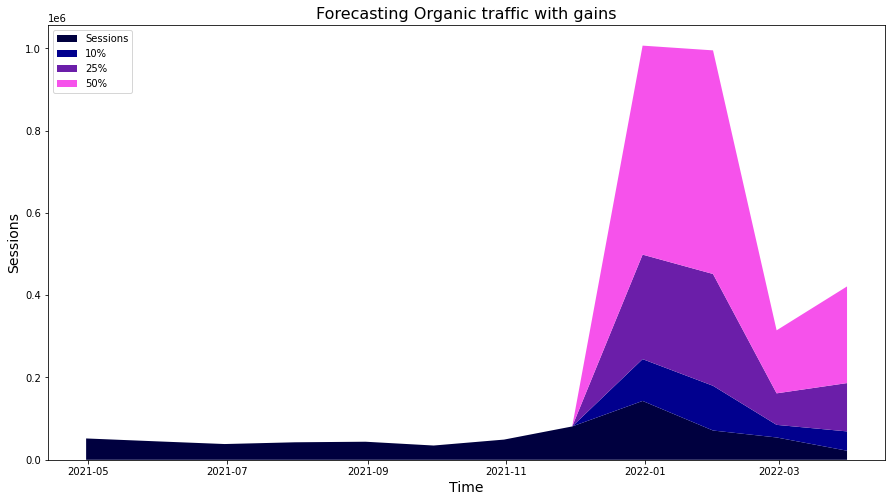

In [20]:
#Plotting the Chart with the forecasting natural sessions and their incrementals by percentage
color_map = ['#00003f','#01008e','#6b1ea9','#f652eb']
Time = forecast__['Month index']
Td = forecast__.iloc[:,1:].to_dict('list')

fig, ax = plt.subplots(figsize=(15,8))
ax.stackplot(Time, Td.values(),
             labels=Td.keys(), colors = color_map)
ax.legend(loc='upper left')
ax.set_title('Forecasting Organic traffic with gains',size=16)
ax.set_xlabel('Time',size=14)
ax.set_ylabel('Sessions',size=14)

plt.show()